# Purpose
The point of this notebook is to demonstrate how to perform at least one type of visual, conditional independence test.

In particular, the notebook will show how to visually test the following implication<br>
$
\begin{aligned}
P \left( X_1 \mid X_2, Z \right) &= P \left( X_1 \mid Z \right) \\
\int x_1 P \left( X_1 \mid X_2, Z \right) \partial{x_1}  &= \int x_1 P \left( X_1 \mid Z \right) \partial{x_1} \\
E \left[ X_1 \mid X_2, Z \right] &= E \left[ X_1 \mid Z \right]
\end{aligned}
$

In other words, if $X_1$ is conditionally independent of $X_2$ given $Z$, then the expectation of $X_1$ conditional on $X_2$ and $Z$ is equal to the expectation of $X_1$ conditional on just $Z$. This implies that shuffling the $X_2$ columns should make no difference to predicting $X_1$ once we've included the $Z$ column while predicting. This implies that we can permute the $X_2$ column and that it shouldn't substantively matter for predicting $X_1$ given that we've included $Z$ as a predictor.

In [1]:
# Declare hyperparameters for testing
MIN_SAMPLES_LEAF = 40
NUM_PERMUTATIONS = 100

# Declare the columns to be used for testing
x1_col = 'total_travel_time'
x2_col = 'total_travel_cost'
z_col = 'total_travel_distance'
mode_id_col = 'mode_id'

# Set the colors for plotting
orig_color = '#045a8d'
permuted_color = '#a6bddb'

# Declare paths to data
DATA_PATH =\
    '../../data/raw/spring_2016_all_bay_area_long_format_plus_cross_bay_col.csv'

In [2]:
import sys
from pdb import set_trace as bp

import numpy as np
import pandas as pd
from scipy.stats import multinomial

import seaborn as sbn
import matplotlib.pyplot as plt
%matplotlib inline

from tqdm.notebook import tqdm

from sklearn.ensemble import ExtraTreesRegressor, RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

# sys.path.insert(0, '../../src/')
# import viz

In [3]:
# Load the raw data
df = pd.read_csv(DATA_PATH)

In [ ]:
def _make_regressor(x_2d, y, seed=None):
    # regressor_kwargs =\	    regressor = LinearRegression()
    #     {'min_samples_leaf': MIN_SAMPLES_LEAF,
    #      'max_samples': 0.8}
    # if seed is not None:
    #     regressor_kwargs['random_state'] = seed + 10
    # regressor =\
    #     RandomForestRegressor(**regressor_kwargs)
    regressor = LinearRegression()
    regressor.fit(x_2d, y)
    return regressor


def computed_vs_obs_r2(df,
                       x1_col,
                       x2_col,
                       z_col,
                       mode_id_col,
                       seed,
                       progress=True):
    # Get the values to be used for testing
    filter_array = (df[mode_id_col] == 1).values
    obs_x1 = df[x1_col].values[filter_array]
    obs_x2 = df[x2_col].values[filter_array]
    obs_z = df[z_col].values[filter_array]

    # Combine the various predictors
    combined_obs_predictors =\
        np.concatenate((obs_x2[:, None], obs_z[:, None]), axis=1)

    # Determine the number of rows being plotted
    num_rows = obs_x1.shape[0]

    # Create a regressor to be used to compute the conditional expectations
    regressor = _make_regressor(combined_obs_predictors, obs_x1, seed)

    # Get the observed expectations
    obs_expectation = regressor.predict(combined_obs_predictors)
    obs_r2 = r2_score(obs_x1, obs_expectation)

    # Initialize arrays to store the permuted expectations and r2's
    permuted_expectations = np.empty((num_rows, NUM_PERMUTATIONS))
    permuted_r2 = np.empty(NUM_PERMUTATIONS, dtype=float)

    # Get the permuted expectations
    shuffled_index_array = np.arange(num_rows)

    iterable = range(NUM_PERMUTATIONS)
    if progress:
        iterable = tqdm(iterable)

    for i in iterable:
        # Shuffle the index array
        np.random.shuffle(shuffled_index_array)
        # Get the new set of permuted X_2 values
        current_x2 = obs_x2[shuffled_index_array]
        # Get the current combined predictors
        current_predictors =\
            np.concatenate((current_x2[:, None], obs_z[:, None]), axis=1)
        # Fit a new model and store the current expectation
        current_regressor =\
            _make_regressor(current_predictors, obs_x1, seed)
        permuted_expectations[:, i] =\
            current_regressor.predict(current_predictors)
        permuted_r2[i] = r2_score(obs_x1, permuted_expectations[:, i])
    return obs_r2, permuted_r2


def visualize_permutation_results(obs_r2,
                                  permuted_r2,
                                  verbose=True,
                                  show=True,
                                  close=False):
    fig, ax = plt.subplots(figsize=(10, 6))
    p_value = (obs_r2 < permuted_r2).mean()

    if verbose:
        msg =\
            'The p-value of the permutation C.I.T. is {:.2f}.'
        print(msg.format(p_value))

    sbn.kdeplot(
        permuted_r2, ax=ax, color=permuted_color, label='Simulated')
    ax.vlines(obs_r2,
              ax.get_ylim()[0],
              ax.get_ylim()[1],
              linestyle='dashed',
              color='black',
              label='Observed\np-val: {:0.3f}'.format(p_value,
                                                      precision=1))

    ax.set_xlabel(r'$r^2$', fontsize=13)
    ax.set_ylabel(
        'Density', fontdict={'fontsize':13, 'rotation':0}, labelpad=40)
    ax.legend(loc='best')
    sbn.despine()
    if show:
        fig.show()
    if close:
        plt.close(fig=fig)
    return p_value


def visual_permutation_test(df,
                            x1_col,
                            x2_col,
                            z_col,
                            mode_id_col,
                            seed=1038,
                            progress=True,
                            verbose=True,
                            show=True,
                            close=False):
    # Set a random seed for reproducibility
    if seed is not None:
        np.random.seed(seed)

    # Compute the observed r2 and the permuted r2's
    obs_r2, permuted_r2 =\
        computed_vs_obs_r2(
            df, x1_col, x2_col, z_col,
            mode_id_col, seed, progress=progress)

    # Visualize the results of the permutation test
    p_value =\
        visualize_permutation_results(
            obs_r2, permuted_r2, verbose=verbose, show=show, close=close)
    return p_value




total_travel_time vs total_travel_cost, 
conditional on total_travel_distance



The p-value of the permutation C.I.T. is 0.00.


<ipython-input-4-74788f21e1d6>:99: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


0.0

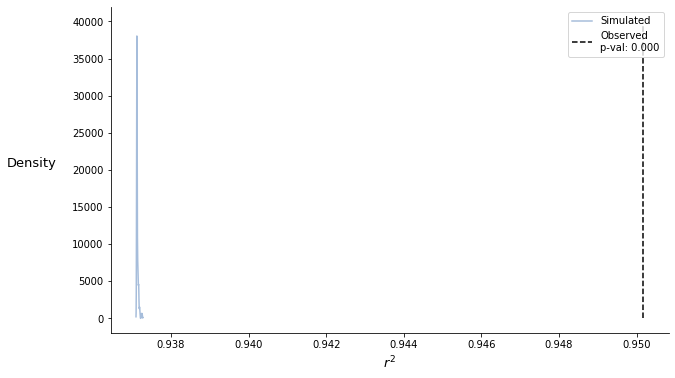

In [5]:
title_str = '{} vs {}, \nconditional on {}'
print(title_str.format(x1_col, x2_col, z_col))
visual_permutation_test(df, x1_col, x2_col, z_col, mode_id_col)

total_travel_cost vs cross_bay, 
conditional on total_travel_distance



The p-value of the permutation C.I.T. is 0.00.


<ipython-input-4-74788f21e1d6>:99: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


0.0

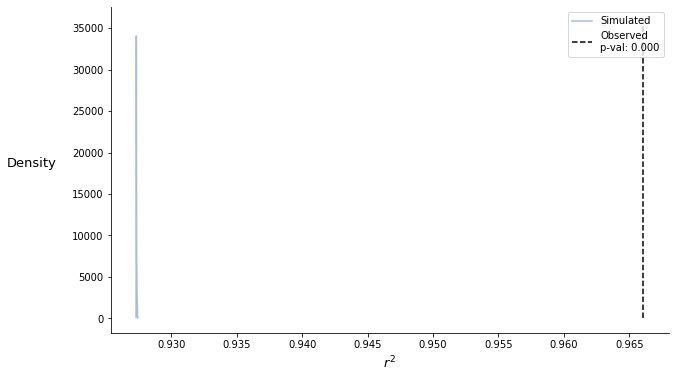

In [6]:
new_x1_col = 'total_travel_cost'
new_x2_col = 'cross_bay'

title_str = '{} vs {}, \nconditional on {}'
print(title_str.format(new_x1_col, new_x2_col, z_col))

visual_permutation_test(df, new_x1_col, new_x2_col, z_col, mode_id_col)

## Test `visual_permutation_test`

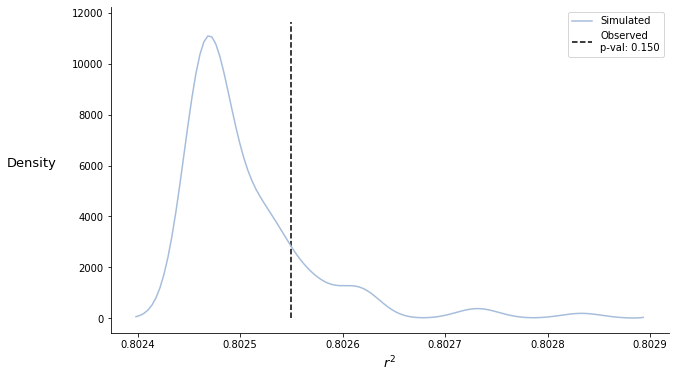

In [7]:
# Figure out how many observations to simulate, based on real data
num_drive_alone_obs = (df.mode_id == 1).sum()
# Determine how many simulations to carry out
NUM_TEST_SIM = 200

# Initialize an array to store the simulated p-values
test_p_vals = np.empty((NUM_TEST_SIM,), dtype=float)

# Set a random seed for reproducibility
np.random.seed(340)

# Compute the p-values of the visual permutation test when the
# null-hypothesis is true.
for i in tqdm(range(NUM_TEST_SIM)):
    # Simulate data that, by construction, satisfies x2 indep x1 given z
    sim_z = np.random.normal(size=num_drive_alone_obs)
    sim_x1 = sim_z + 0.5 * np.random.normal(size=num_drive_alone_obs)
    sim_x2 = sim_z - 0.01 * np.random.uniform(size=num_drive_alone_obs)

    # Determine which simulations to plot.
    # Just plot 1 simulation for visual comparison with real data
    current_close = True if i != 0 else False

    # Package the simulated data together for the test
    temp_df =\
        pd.DataFrame({'sim_z': sim_z,
                      'sim_x1': sim_x1,
                      'sim_x2': sim_x2,
                      'mode_id': tuple(1 for x in sim_x2),
                    })

    # Carry out the permutation test
    current_p =\
        visual_permutation_test(temp_df,
                                'sim_x1',
                                'sim_x2',
                                'sim_z',
                                mode_id_col,
                                seed=None,
                                progress=False,
                                verbose=False,
                                show=False,
                                close=current_close)
    # Store the resulting p-values
    test_p_vals[i] = current_p

In [ ]:
# Create a distribution of p-values that is for sure are uniformly distributed
null_histogram_dist = multinomial(NUM_TEST_SIM, [0.1 for x in range(10)])

null_hist_samples = null_histogram_dist.rvs(100)
null_hist_mean = null_histogram_dist.mean()
null_hist_upper_bound = np.percentile(null_hist_samples, 95, axis=0)
null_hist_lower_bound = np.percentile(null_hist_samples, 5, axis=0)

# Plot the distribution of our test p-values versus the p-values from
# a uniform distriburtion
fig, ax = plt.subplots(figsize=(10, 6))

plot_categories = [0.05 + 0.1 * x for x in range(10)]
ax.fill_between(plot_categories,
                null_hist_upper_bound,
                null_hist_lower_bound,
                color=permuted_color,
                label='Null 95% Distribution',
                alpha=0.5,
                zorder=2)

ax.hlines(null_hist_mean, 0, 1, label='Null Mean')

ax.hist(test_p_vals, bins=10, label='Observed', zorder=0)

ax.scatter(
    plot_categories,
    null_hist_upper_bound,
    label='Null 95% Upper Bound',
    color=permuted_color,
    marker='+',
    zorder=1)

ax.scatter(
    plot_categories,
    null_hist_lower_bound,
    label='Null 5% Lower Bound',
    color=permuted_color,
    marker='*',
    zorder=1)

ax.legend(loc=(1.05, 0.75))
ax.set_xlabel('p-values', fontsize=13)
ax.set_ylabel('Num Observations', rotation=0, labelpad=70, fontsize=13)

sbn.despine()

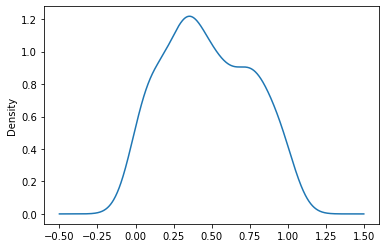

In [9]:
pd.Series(test_p_vals).plot(kind='kde')

## Conclusions
- From the last two plots, we can see that under the null hypothesis of $X_1$ independent of $X_2$ given $Z$, we get p-values that close to uniformly distributed.<br>
This means the permutation p-values in `visual_permutation_test` are unlikely to be overly-optimistic.<br>
In other words, we can feel safe(r) about relying on this test to distinguish conditional dependence from independence.
- From the first two plots of this notebook, we can see from applying the `visual_permutation_test` that:
  - travel time and travel cost are not conditionally independent given travel distance.
  - travel cost and `cross_bay` are not conditionally independent given travel distance (as one might expect since one's travel cost is a function of whether or not one pays tolls to cross the Bay Bridge).